## House Prices - Advanced Regression Techniques

****** HERE WILL BE ID *******

### TL;DR

### Part 1 Imports and Definitions


In [ ]:
# import numpy, matplotlib, etc. 
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import sweetviz as sw
import os
from tqdm import tqdm


# sklearn imports
from sklearn import metrics
from sklearn import pipeline
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import neural_network
from sklearn import model_selection
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split


# define plt settings
sns.set_theme()
plt.rcParams["font.size"] = 20
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["legend.fontsize"] = 20
plt.rcParams["legend.markerscale"] = 1.5
plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams["legend.title_fontsize"] = 20


- define the input and output folders


In [ ]:
input_folder = "input/"

train_data_path = os.path.join(input_folder, "train.csv")
test_data_path = os.path.join(input_folder, "test.csv")

  - define the show graphs variable


In [ ]:
SHOW_GRAPHS = True

#### Load the traning data
  - Load the csv data to variables


In [ ]:
train_data = pd.read_csv(train_data_path)

test_data = pd.read_csv(test_data_path)

# display the first few rows of the data
train_data.head()

### Part 2 Data Investigation EDA


#### Data Cleaning

- Remove the id column


In [ ]:
# Drop the "Id" column from the train_data DataFrame
train_data_id = train_data["Id"]
train_data = train_data.drop("Id", axis=1)

# Drop the "Id" column from the test_data DataFrame
test_id = test_data["Id"]
test_data = test_data.drop("Id", axis=1)


train_data.head()

- Count the number of feuatures

In [ ]:
print(f"Number of features: {train_data.shape[1]}")

Get summary statistics for the training dataset show only the numerical columns


In [ ]:
train_data.describe()


- Get the data types of the columns in the training dataset


In [ ]:
display(train_data.info())

We can see that most of the data is object

- Check for missing values

In [ ]:
def show_missing_data_with_percentage(data):
    print("Missing values in the dataset:")
    print("-----------------------------------------")
    print("Total Rows: ", len(data))
    print("_________________________________________")
    # Display missing values in each column of the training dataset
    missing_values = data.isnull().sum()
    missing_percentage = (missing_values / len(train_data)) * 100
    missing_data = pd.concat([missing_values, missing_percentage], axis=1, keys=['Missing Values', 'Percentage'])
    missing_data.sort_values(by='Missing Values', ascending=False, inplace=True)
    print(missing_data.head(20))
    
    print("\n\nTotal missing values: ", missing_data['Missing Values'].sum())
    
    


In [ ]:
# Display missing values in the training dataset
show_missing_data_with_percentage(train_data)

We can see that the columns "Alley", "PoolQC", "Fence", "MiscFeature" have a lot of missing values.

- Handle the missing data<br><br>
First step to remove highly missing features (by threshold)

In [ ]:
def drop_highly_missing_features(data, fetures_to_drop):
    data = data.drop(fetures_to_drop, axis=1)
    return data


def find_features_with_missing_values_threshold(data, threshold):
    missing_values = data.isnull().sum()
    missing_percentage = (missing_values / len(train_data)) * 100
    missing_data = pd.concat([missing_values, missing_percentage], axis=1, keys=['Missing Values', 'Percentage'])
    missing_data.sort_values(by='Missing Values', ascending=False, inplace=True)
    features_to_drop = missing_data[missing_data['Percentage'] > threshold].index
    return features_to_drop


In [ ]:
# Set the threshold for missing values to remove
threshold = 80
# for 80 it return # ["Alley", "PoolQC", "Fence", "MiscFeature"]
drop_features = find_features_with_missing_values_threshold(train_data, threshold) 


train_data = drop_highly_missing_features(train_data, drop_features)

test_data = drop_highly_missing_features(test_data, drop_features)

print("Remove this features: ", drop_features)

In [ ]:
show_missing_data_with_percentage(train_data)

Handling Missing Values for Numerical Features

In [ ]:
# fill missing numerical values with median
def handle_missing_values_numerical(data):
    for column in data.select_dtypes(include=[np.number]).columns:
        data[column].fillna(data[column].median(), inplace=True)
    return data

Handling Missing Values for Categorical Features

In [ ]:
# Fill missing categorical values with most frequent value
def handle_missing_values_categorical(data):
    for column in data.select_dtypes(include=[object]).columns:
        data[column].fillna(data[column].mode()[0], inplace=True)
    return data

One function to handle the missing values

In [ ]:
def handle_missing_values(data):
    data = handle_missing_values_numerical(data)
    data = handle_missing_values_categorical(data)
    return data

In [ ]:
# fill the missing values in the train data
train_data = handle_missing_values(train_data)

# fill the missing values in the test data
test_data = handle_missing_values(test_data)

Verify No More Missing Values

In [ ]:
print("\nMissing values in the training dataset after filling:")
print(train_data.isnull().sum().sum())

print("\nMissing values in the test dataset after filling:")
print(test_data.isnull().sum().sum())


In [ ]:
train_data.head()

Convert Categorical Features to Numeric Using One-Hot Encoding

In [ ]:
print("Data types in training data:")
print(train_data.dtypes)


#### Feature Analysis & Visualization 

Distribution of SalePrice

In [ ]:
if SHOW_GRAPHS:
    plt.figure(figsize=(11, 7))
    sns.histplot(train_data['SalePrice'], kde=True, bins=30, color='blue')
    plt.title('Distribution of SalePrice')
    plt.xlabel('SalePrice')
    plt.ylabel('Count')
    plt.show()
    

Normal Probability

In [ ]:
from scipy import stats

if SHOW_GRAPHS:
    plt.figure(figsize=(10, 6))
    stats.probplot(train_data['SalePrice'], dist="norm", plot=plt)
    plt.title('Normal Probability Plot of SalePrice')
    plt.show()

Histogram for SalePrice

In [ ]:
if SHOW_GRAPHS:
    fig = px.histogram(train_data, x='SalePrice', title='Distribution of SalePrice')
    fig.show()

We can see the distribution of SalePrice

- Box plot for SalePrice

In [ ]:
if SHOW_GRAPHS:
    fig = px.box(train_data, y='SalePrice', title='Boxplot of SalePrice')
    fig.show()

OverallQual: Rates the overall material and finish of the house

In [ ]:

if SHOW_GRAPHS:
    overall_qual_mean = train_data.groupby('OverallQual')['SalePrice'].mean()
    fig = px.bar(overall_qual_mean, x=overall_qual_mean.index, y='SalePrice', title='OverallQual vs SalePrice')
    fig.add_trace(go.Scatter(x=overall_qual_mean.index, y=overall_qual_mean.values, mode='lines', name='lines'))
    fig.show()


We calculate the correlation of each feature with SalePrice and sort them to identify the strongest relationships.
- To do so we must encode the categorical columns

In [ ]:

# Split the data to numerical and categorical columns
numerical_columns = train_data.select_dtypes(include=["int64", 'float64']).columns
categorical_columns = train_data.select_dtypes(include=["object"]).columns


# Encode the categorical columns
categorical_columns_encoded = pd.get_dummies(train_data[categorical_columns])

# Combine the numerical and encoded categorical columns
train_data_encoded = pd.concat([train_data[numerical_columns], categorical_columns_encoded], axis=1)


# Create a correlation matrix
correlation_matrix = train_data_encoded.corr().abs()


- Change N to the number of top features you want to analyze 

In [ ]:
N = 20

# Get the top N correlated features with the target variable
top_correlated_features = correlation_matrix['SalePrice'].sort_values(ascending=False).head(N).index.tolist()

# Filter the correlation matrix to get the top N correlated features
filtered_correlation_matrix = correlation_matrix.loc[top_correlated_features, top_correlated_features]

Top correlation with SalePrice

In [ ]:
print(f"Top {N} features with the highest correlation with SalePrice:")
print(filtered_correlation_matrix['SalePrice'])

Pairplot Visualizing Correlation

In [ ]:
if SHOW_GRAPHS:
    sns.pairplot(train_data[top_correlated_features[:5]], height=3.5)

Heatmap for correlation matrix


In [ ]:
import plotly.graph_objects as go

def show_top_correlated_features(correlation_matrix, n):
    # Display the heatmap of the correlation matrix with numbers in each cell
    fig = go.Figure(data=go.Heatmap(
        z=correlation_matrix.values,
        x=correlation_matrix.columns,
        y=correlation_matrix.columns,
        colorscale='Viridis',
        text=correlation_matrix.values.round(2),  # Round values for display
        texttemplate="%{text}",
        showscale=True))
    fig.update_layout(title=f"Top {n} Correlated Features", width=1000, height=800)
    fig.show()

In [ ]:
if SHOW_GRAPHS:
    show_top_correlated_features(filtered_correlation_matrix, N)

#### Data Standardization & Outliers 

Descriptive statistics

In [ ]:
train_data['SalePrice'].describe()

Standardize the data

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# Standardizing data
saleprice_scaled = StandardScaler().fit_transform(np.array(train_data['SalePrice']).reshape(-1, 1));
low_range = saleprice_scaled[saleprice_scaled[:, 0].argsort()][:10]
high_range = saleprice_scaled[saleprice_scaled[:, 0].argsort()][-10:]

# Display the low and high range of the SalePrice after standardization
print('\nOuter range (low) of the distribution:')
print(low_range)
print("\n----------------------------------------")
print('\nOuter range (high) of the distribution:')
print(high_range)

Find and remove outliers

- Function to find the outliers

In [ ]:
import plotly.graph_objects as go

def show_outliers(data, target, compare):
    # Create a scatter plot for data points
    fig = go.Figure(data=go.Scatter(
        x=data[compare],
        y=data[target],
        mode='markers',
        text=data.index,  # Assuming the index is the ID you want to show on hover
        hoverinfo='text+x+y',  # Show ID, x (compare), and y (target) values on hover
        marker=dict(color='blue', size=10, line=dict(width=1, color='DarkSlateGrey')),
        name='Data Points'
    ))
    
    # Identify outliers (this is an example, adjust according to your criteria)
    outliers = data[data[compare] > data[compare].quantile(0.99)]  # Top 1% as outliers
    
    # Add outliers to the plot with a different color
    fig.add_trace(go.Scatter(
        x=outliers[compare],
        y=outliers[target],
        mode='markers',
        text=outliers.index,  # Assuming the index is the ID you want to show on hover
        hoverinfo='text+x+y',  # Show ID, x (compare), and y (target) values on hover
        marker=dict(color='red', size=12, line=dict(width=1, color='DarkSlateGrey')),
        name='Outliers'
    ))
    
    # Update plot layout
    fig.update_layout(title=f'{target} vs {compare}',
                      xaxis_title=compare,
                      yaxis_title=target,
                      hovermode='closest')
    
    fig.show()

In [ ]:
# remove outliers by index
def remove_outliers_by_index(data, index):
    try:
        if isinstance(index, list):
            for i in index:
                data = data.drop(i)
        else:
            data = data.drop(index)
    except KeyError:
        print("Index not found")
    return data

- GrLivArea: Above grade (ground) living area square feet

In [ ]:
# show the SalePrice vs GrLivArea, and the id of the outliers
if SHOW_GRAPHS:
    show_outliers(train_data, 'SalePrice', 'GrLivArea')

In [ ]:
# Remove the outliers points
index_list = [523, 1298]
train_data = remove_outliers_by_index(train_data, index_list)
show_outliers(train_data, 'SalePrice', 'GrLivArea')

- TotalBsmtSF: Total square feet of basement area

In [ ]:
if SHOW_GRAPHS:
    show_outliers(train_data, 'SalePrice', 'TotalBsmtSF')

In [ ]:
# remove the outliers points
index_list = [440, 496, 332]
train_data = remove_outliers_by_index(train_data, index_list)

show_outliers(train_data, 'SalePrice', 'TotalBsmtSF')

Histogram probability plot

In [117]:
import seaborn as sns
from scipy.stats import norm

def show_probability_plot(data, target):
    # Create the Histogram
       # Show Histogram with a normal distribution fit line
    sns.histplot(train_data[target], kde=True, color="blue", stat="density")
    # Overlay the normal distribution fit
    mean, std = norm.fit(train_data[target])
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mean, std)
    plt.plot(x, p, 'k', linewidth=2)
    title = "Fit results: mean = %.2f,  std = %.2f" % (mean, std)
    plt.title(title)
    
    # Normal probability plot
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    stats.probplot(train_data[target], dist="norm", plot=ax)  # Use actual data for the plot
    ax.set_title('Normal Probability Plot of {}'.format(target))
    plt.show()
    

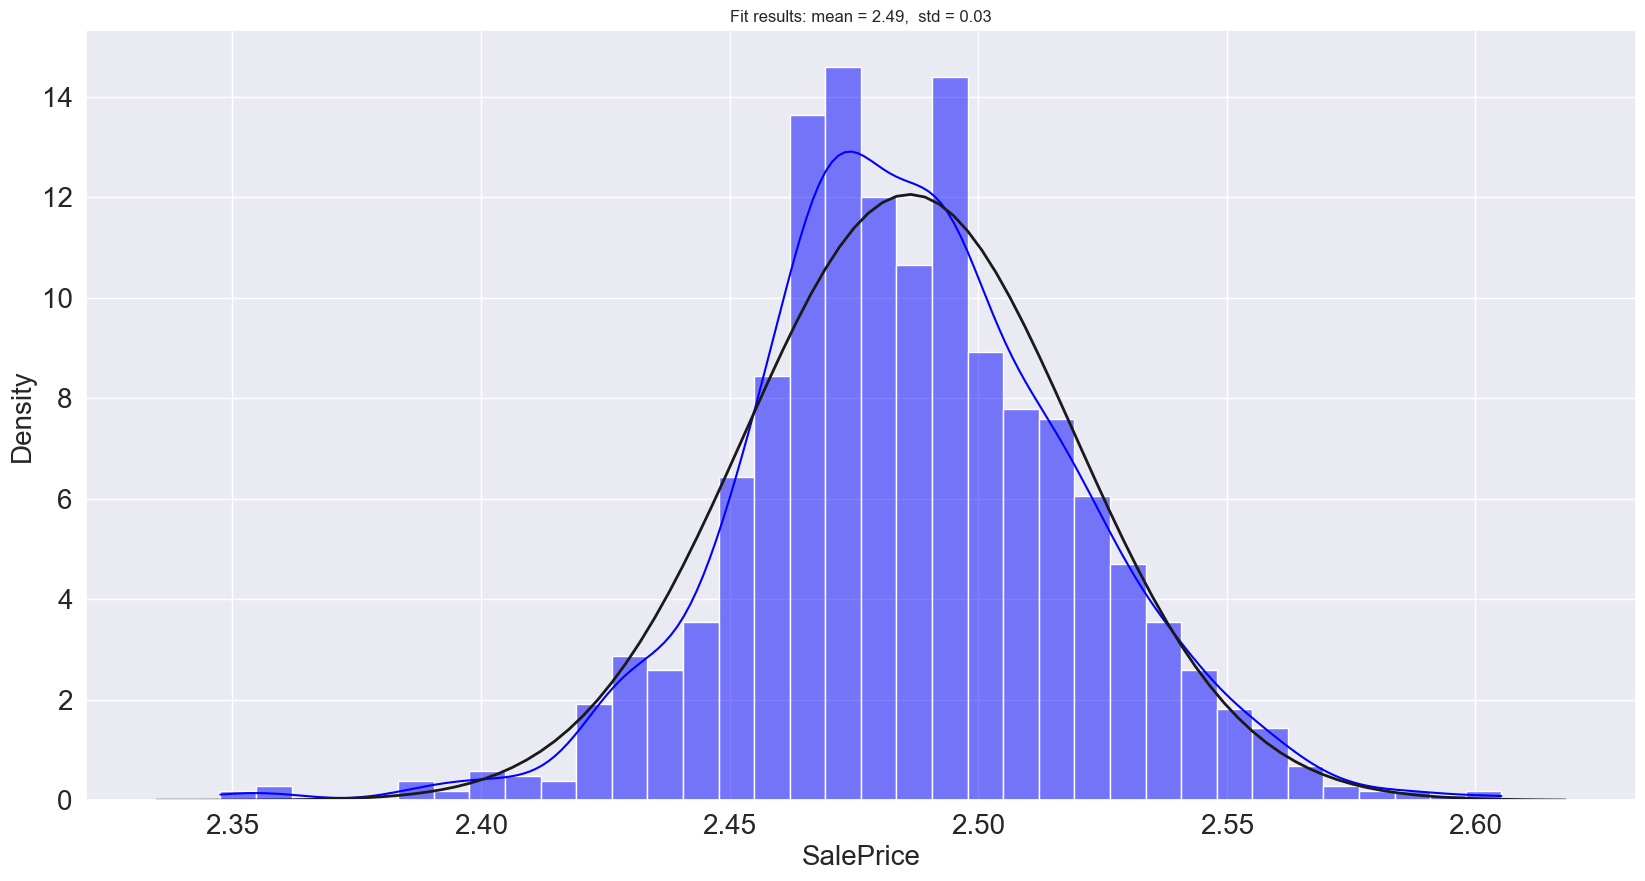

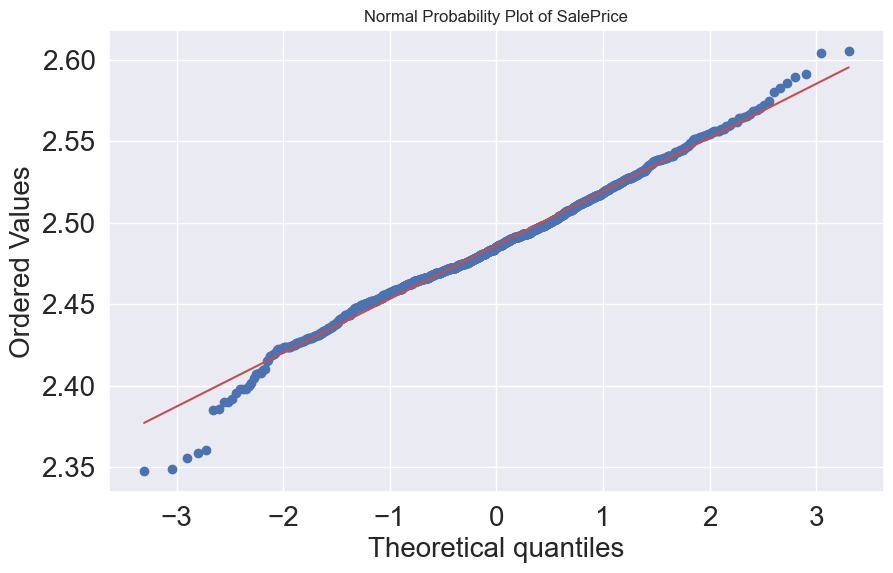

In [119]:
if SHOW_GRAPHS:
    show_probability_plot(train_data, 'SalePrice')

SalePrice is right skewed, so we need to transform it to be normally distributed


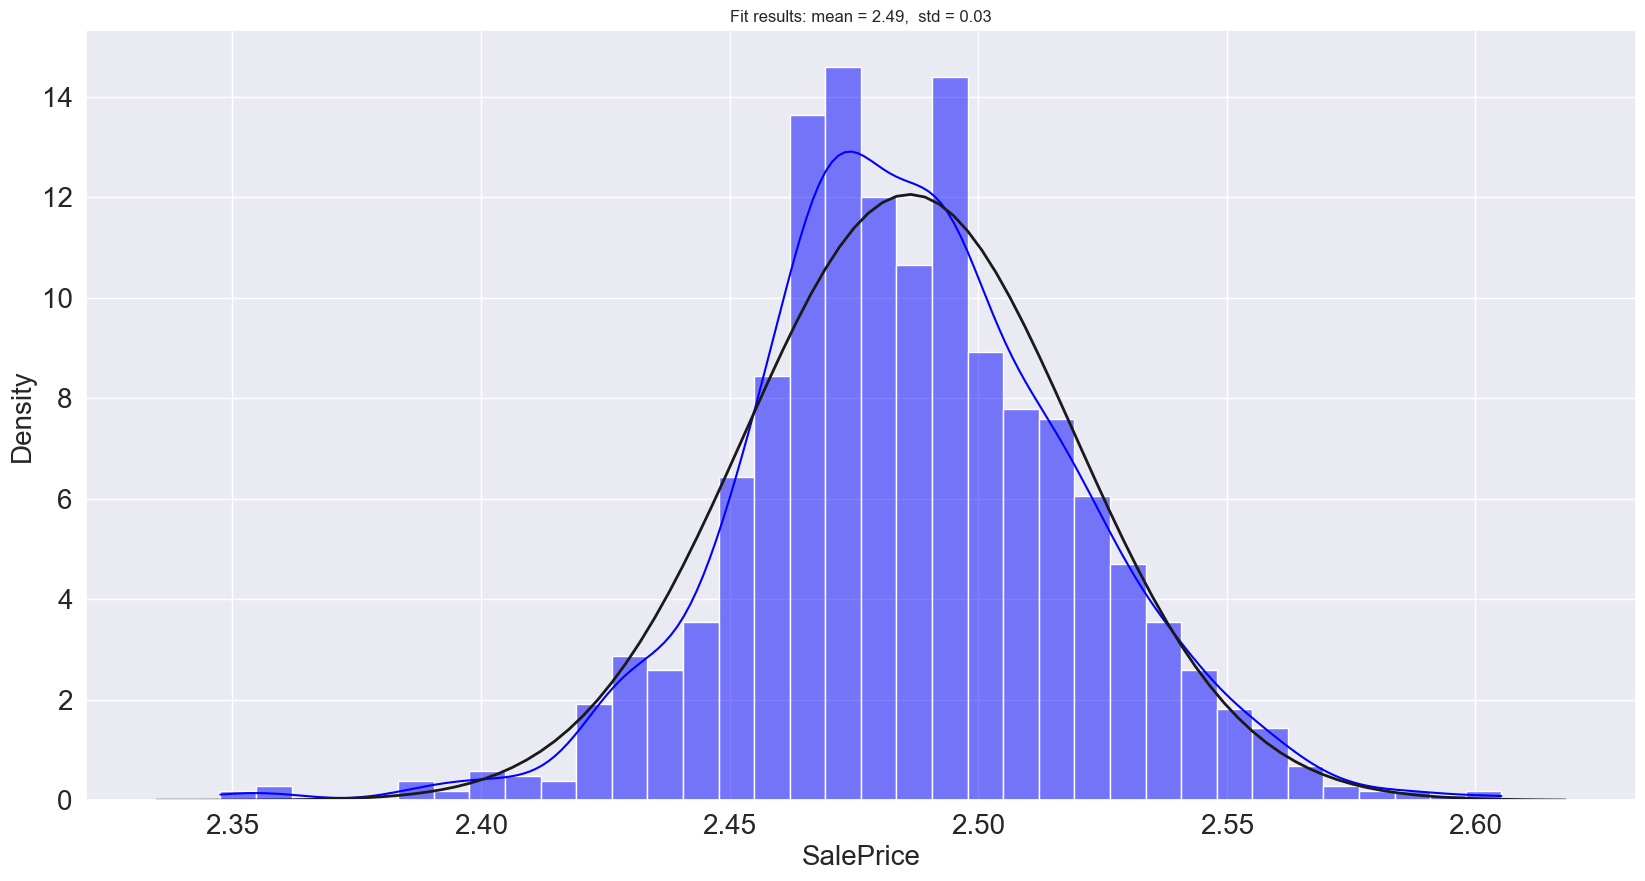

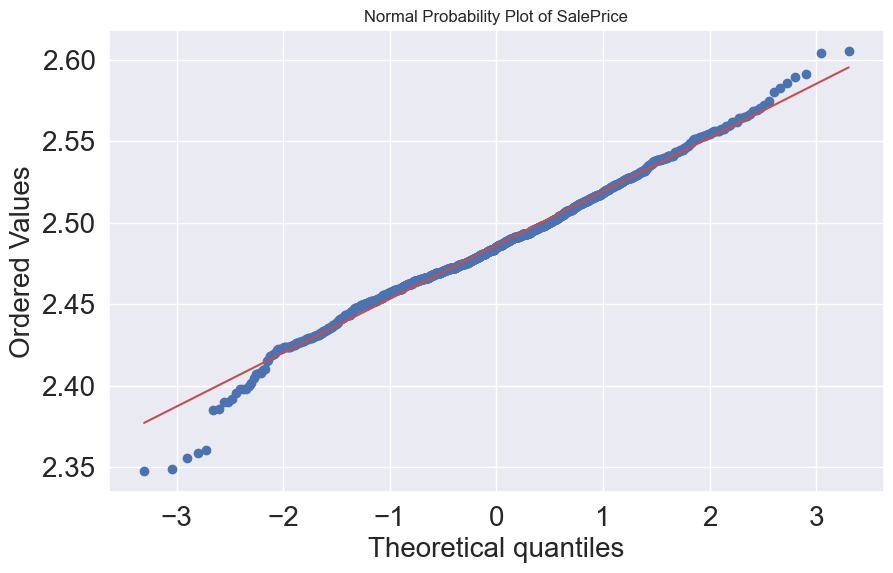

In [116]:
# Log transformation of the target variable
train_data['SalePrice'] = np.log(train_data['SalePrice'])

if SHOW_GRAPHS:
    show_probability_plot(train_data)

We will check GrLivArea

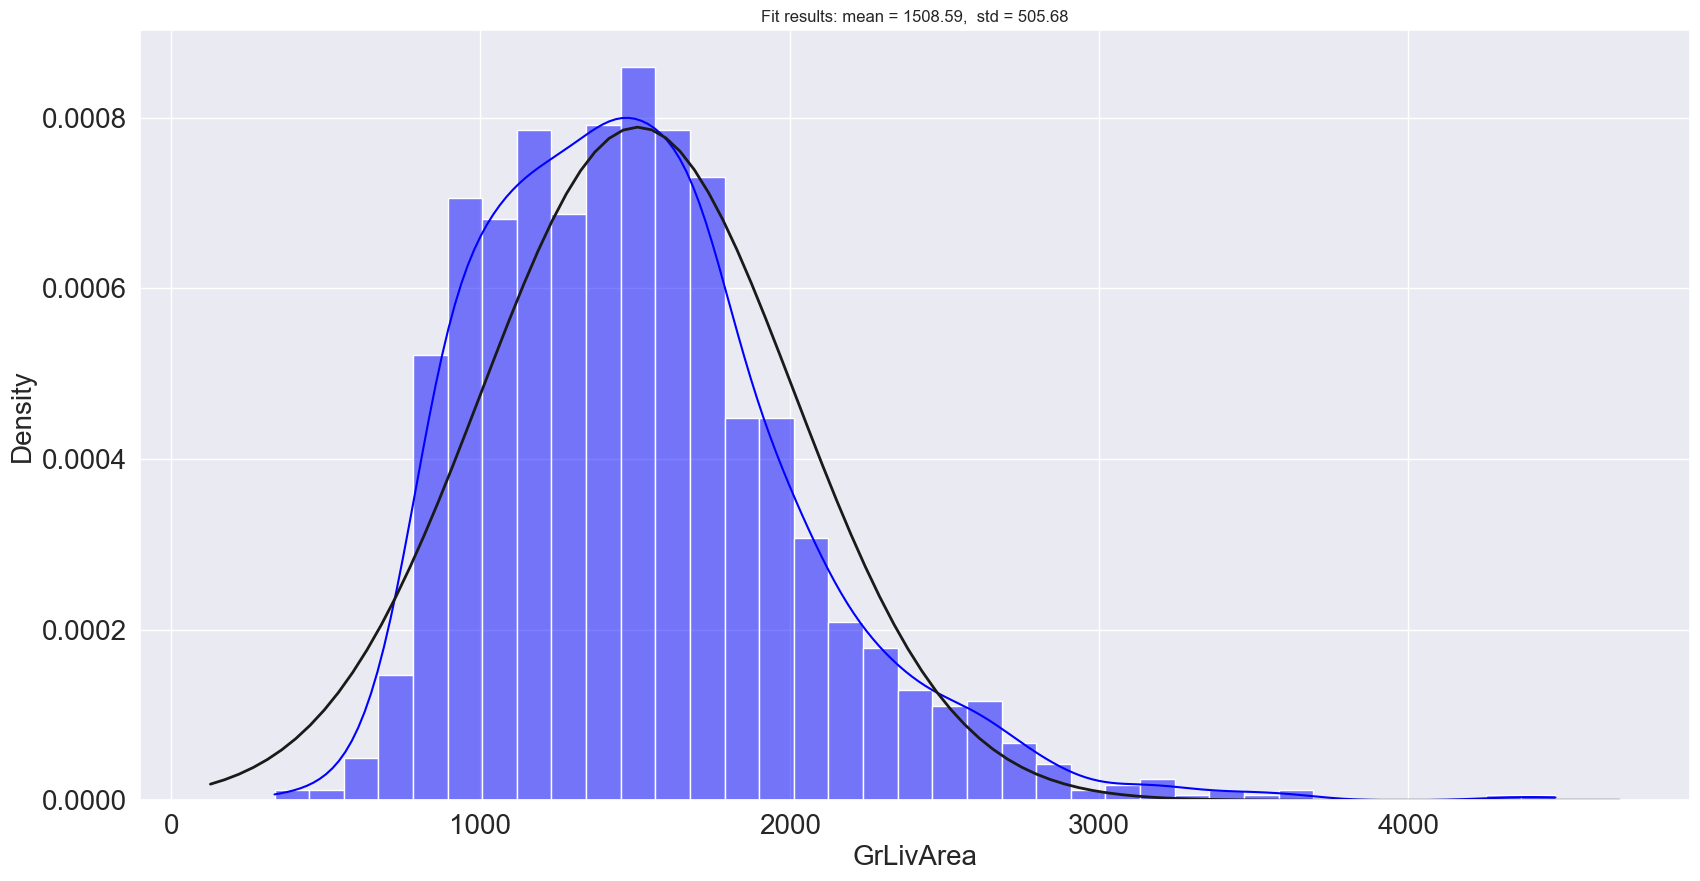

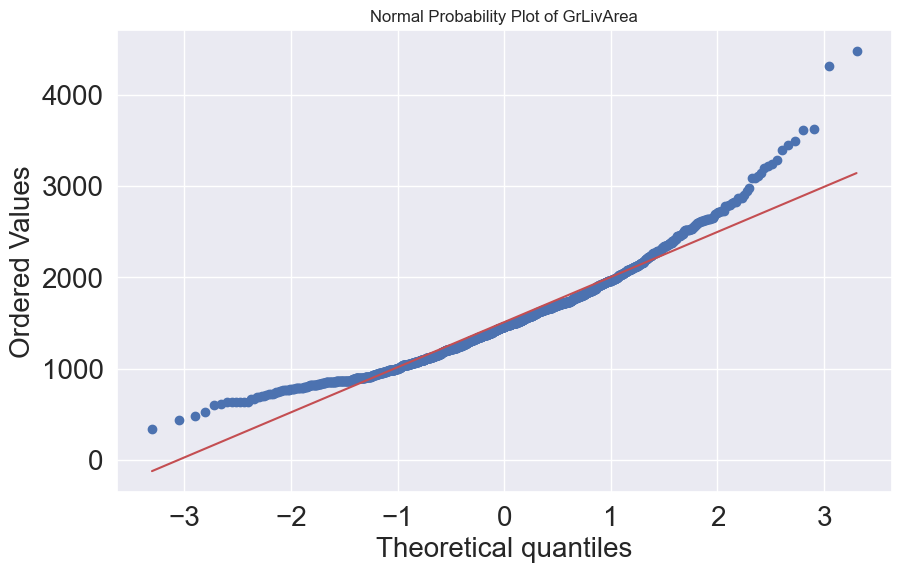

In [120]:
# Show histogram and probability plot for GrLivArea
if SHOW_GRAPHS:
    show_probability_plot(train_data, 'GrLivArea')

GrLivArea is right skewed, so we need to transform it to be normally distributed


#### Feature Engineering

Total Square Footage
- We create a new feature TotalSF by summing up the total basement square footage, first floor square footage, second floor square footage, and garage area. This feature represents the total square footage of the house.

In [ ]:
features_engineering_list = []

# create TotalSF feature
def create_TotalSF_feature(data, features_engineering_list=None):
    data['TotalSqureF'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF'] + data['GarageArea']
    if features_engineering_list is not None:
        features_engineering_list.append('TotalSqureF')
    return data

# Create the TotalSF feature for the train and test data
train_data = create_TotalSF_feature(train_data, features_engineering_list)

test_data = create_TotalSF_feature(test_data)

Age of the House
- We calculate the age of the house at the time of sale by subtracting the year the house was built from the year it was sold.

In [ ]:
# create age_of_house feature
def create_age_of_house_feature(data, features_engineering_list=None):
    data['AgeOfHouse'] = data['YrSold'] - data['YearBuilt']
    if features_engineering_list is not None:
        features_engineering_list.append('AgeOfHouse')
    return data


# Create the AgeOfHouse feature for the train and test data
train_data = create_age_of_house_feature(train_data, features_engineering_list)

test_data = create_age_of_house_feature(test_data)

Age of the Renovation
- We calculate the age of the house since its most recent renovation by subtracting the year of the most recent renovation from the year it was sold.

In [ ]:
# create age_of_renovation feature
def create_age_of_renovation_feature(data, features_engineering_list=None):
    data['AgeOfRenovation'] = data['YrSold'] - data['YearRemodAdd']
    if features_engineering_list is not None:
        features_engineering_list.append('AgeOfRenovation')
    return data

# Create the AgeOfRenovation feature for the train and test data
train_data = create_age_of_renovation_feature(train_data, features_engineering_list)

test_data = create_age_of_renovation_feature(test_data)

Total Bathrooms
- We create a new feature TotalBath by summing up the number of full and half bathrooms in the basement and above grade, with half bathrooms counted as 0.5.

In [ ]:
# create TotalBath feature
def create_TotalBath_feature(data, features_engineering_list=None):
    data['TotalBath'] = data['FullBath'] + 0.5 * data['HalfBath'] + data['BsmtFullBath'] + 0.5 * data['BsmtHalfBath']
    if features_engineering_list is not None:
        features_engineering_list.append('TotalBath')
    return data

# Create the TotalBath feature for the train and test data
train_data = create_TotalBath_feature(train_data, features_engineering_list)

test_data = create_TotalBath_feature(test_data)

Total Porch Area
- We create a new feature TotalPorchSF by summing up the area of all porch-related features, representing the total porch area of the house.

In [ ]:
# create TotalPorchSF feature
def create_TotalPorchSF_feature(data, features_engineering_list=None):
    data['TotalPorchSF'] = data['OpenPorchSF'] + data['EnclosedPorch'] + data['3SsnPorch'] + data['ScreenPorch']
    if features_engineering_list is not None:
        features_engineering_list.append('TotalPorchSF')
    return data

# Create the TotalPorchSF feature for the train and test data
train_data = create_TotalPorchSF_feature(train_data, features_engineering_list)

test_data = create_TotalPorchSF_feature(test_data)

Display the New Features

In [ ]:
print(train_data[features_engineering_list].head())


In [ ]:
if SHOW_GRAPHS:
    show_top_correlated_features(train_data, N)

### Part 3 Regression Models & Cross Validation

- Split the data

In [ ]:
test_size = 0.3

In [ ]:
from sklearn.model_selection import cross_val_score


# split the data into features and target variable
X = train_data.drop(['SalePrice'], axis=1)
y = train_data['SalePrice']

# Encode categorical variables
X = pd.get_dummies(X)
X_test = pd.get_dummies(test_data)

# Align the columns in the test set to match the train set
X, X_test = X.align(X_test, join='left', axis=1, fill_value=0)

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=42)

- Standardize the features


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

- Define a function for computing RMSE


In [ ]:
def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=5))
    return rmse.mean()

#### Regression models

We will implementing different regression models<br> evaluating them using Cross Validation, and computing the RMSE

-  Linear Regression

In [ ]:
# Linear Regression
lin_reg = LinearRegression()
lin_reg_rmse = rmse_cv(lin_reg)
print(f"Linear Regression RMSE: {lin_reg_rmse}")

# Fit the model and predict
lin_reg.fit(X_train_scaled, y_train)
y_pred = lin_reg.predict(X_val_scaled)
lin_reg_val_rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"Linear Regression Validation RMSE: {lin_reg_val_rmse}")


- SGD Regressor

In [ ]:
# SGD Regressor
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, random_state=42)
sgd_reg_rmse = rmse_cv(sgd_reg)
print(f"SGD Regressor RMSE: {sgd_reg_rmse}")

# Fit the model and predict
sgd_reg.fit(X_train_scaled, y_train)
y_pred = sgd_reg.predict(X_val_scaled)
sgd_reg_val_rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"SGD Regressor Validation RMSE: {sgd_reg_val_rmse}")


- Ridge Regression

In [ ]:
# Ridge Regression
from sklearn.linear_model import Ridge


ridge_reg = Ridge(alpha=1.0)
ridge_reg_rmse = rmse_cv(ridge_reg)
print(f"Ridge Regression RMSE: {ridge_reg_rmse}")

# Fit the model and predict
ridge_reg.fit(X_train_scaled, y_train)
y_pred = ridge_reg.predict(X_val_scaled)
ridge_reg_val_rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"Ridge Regression Validation RMSE: {ridge_reg_val_rmse}")


- Lasso Regression

In [ ]:
# Lasso Regression
from sklearn.linear_model import Lasso


lasso_reg = Lasso(alpha=0.1)
lasso_reg_rmse = rmse_cv(lasso_reg)
print(f"Lasso Regression RMSE: {lasso_reg_rmse}")

# Fit the model and predict
lasso_reg.fit(X_train_scaled, y_train)
y_pred = lasso_reg.predict(X_val_scaled)
lasso_reg_val_rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"Lasso Regression Validation RMSE: {lasso_reg_val_rmse}")


- Elastic Net Regression

In [ ]:
# Elastic Net Regression
from sklearn.linear_model import ElasticNet


elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net_rmse = rmse_cv(elastic_net)
print(f"Elastic Net Regression RMSE: {elastic_net_rmse}")

# Fit the model and predict
elastic_net.fit(X_train_scaled, y_train)
y_pred = elastic_net.predict(X_val_scaled)
elastic_net_val_rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"Elastic Net Regression Validation RMSE: {elastic_net_val_rmse}")


# Fix the jump!